In [1]:
import json, os, re
import glob
import pickle, time, regex
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

## Cleaning

In [4]:
raw_all = glob.glob('/content/drive/MyDrive/news_analysis/assets/raw_data/*.csv')
df1 = pd.read_csv(raw_all[0])
df2 = pd.read_csv(raw_all[1])
df3 = pd.read_csv(raw_all[2])
df_list = [df1, df2, df3]
new_df = pd.concat(df_list)
new_df.shape

(8720, 4)

In [5]:
raw_all[0]

'/content/drive/MyDrive/news_analysis/assets/raw_data/the_hindu_news_2020_60_days.csv'

In [6]:
new_df.head()

,headline,links,content,labels
0,Sindhu targets Olympics gold,https://www.thehindu.com/sport/other-sports/si...,World champion P.V. Sindhu said it is time to ...,other sports
1,Shotgun selection trials from January 20,https://www.thehindu.com/sport/other-sports/sh...,The second and third shotgun selection trials ...,other sports
2,Supreme Fragrance wins SI Oaks in style,https://www.thehindu.com/sport/races/star-frag...,Robert Foley-trained Supreme Fragrance (Nakha...,races
3,"Prevalent Force, Stormy Knight, Indian Democra...",https://www.thehindu.com/sport/races/prevalent...,"Prevalent Force, Stormy Knight, Indian Democr...",races
4,Awesome One excels,https://www.thehindu.com/sport/races/awesome-o...,Awesome One excelled when the horses were exe...,races


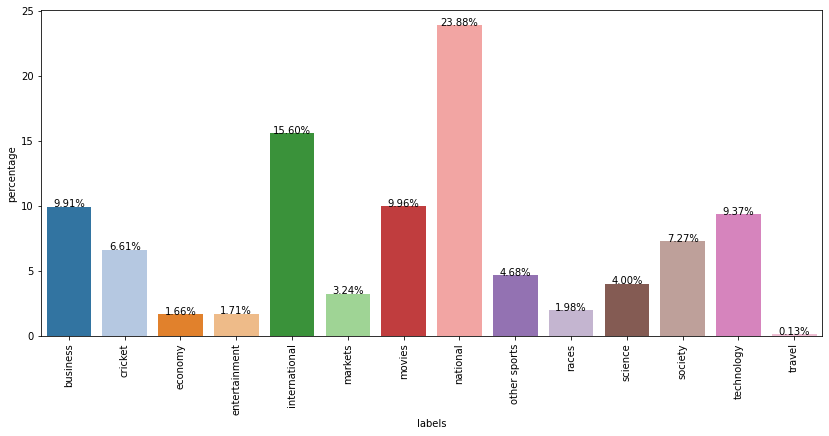

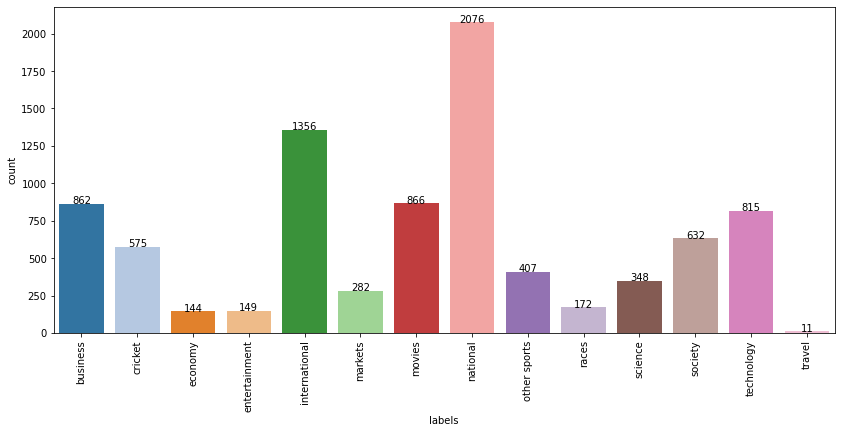

In [7]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, str(int(float(value))), ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def show_values_on_bars_percentage(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def plot_labels_count(df, label_col_name = 'labels', 
                      text_col_name = 'content', 
                      file_name = 'raw_data_labels_count.jpg'):
  df_temp = pd.DataFrame(df.groupby([label_col_name]).count()[text_col_name]).reset_index()
  df_temp = df_temp.rename(columns={"content": "count"})
  df_temp['percentage'] = (df_temp['count']/df_temp['count'].sum()) * 100
  fig = plt.figure(figsize = (14, 6))
  ax = sns.barplot(x = 'labels', y = 'count',data = df_temp, palette='tab20')
  show_values_on_bars(ax)
  plt.xticks(rotation = 90)

  dir_path = '/content/drive/MyDrive/news_analysis/assets/figs'
  file_name = os.path.join(dir_path, file_name)
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
  plt.show()

def plot_labels_percentage(df, label_col_name = 'labels', 
                      text_col_name = 'content', 
                      file_name = 'raw_data_labels_percentage.jpg'):
  df_temp = pd.DataFrame(df.groupby([label_col_name]).count()[text_col_name]).reset_index()
  df_temp = df_temp.rename(columns={"content": "count"})
  df_temp['percentage'] = (df_temp['count']/df_temp['count'].sum()) * 100
  fig = plt.figure(figsize = (14, 6))
  ax = sns.barplot(x = 'labels', y = 'percentage',data = df_temp, palette='tab20')
  show_values_on_bars_percentage(ax)
  plt.xticks(rotation = 90)

  dir_path = '/content/drive/MyDrive/news_analysis/assets/figs'
  file_name = os.path.join(dir_path, file_name)
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
  plt.show()
# df = pd.read_csv(raw_data_path)
plot_labels_percentage(new_df)
plot_labels_count(new_df)

In [8]:
df_temp = pd.DataFrame(new_df.groupby(['labels']).count()['content']).reset_index()
df_temp = df_temp.rename(columns={"content": "count"})
df_temp['percentage'] = (df_temp['count']/df_temp['count'].sum()) * 100
df_temp

,labels,count,percentage
0,business,862,9.913744
1,cricket,575,6.612996
2,economy,144,1.656124
3,entertainment,149,1.713629
4,international,1356,15.595170
5,markets,282,3.243243
6,movies,866,9.959747
7,national,2076,23.875791
8,other sports,407,4.680851
9,races,172,1.978148


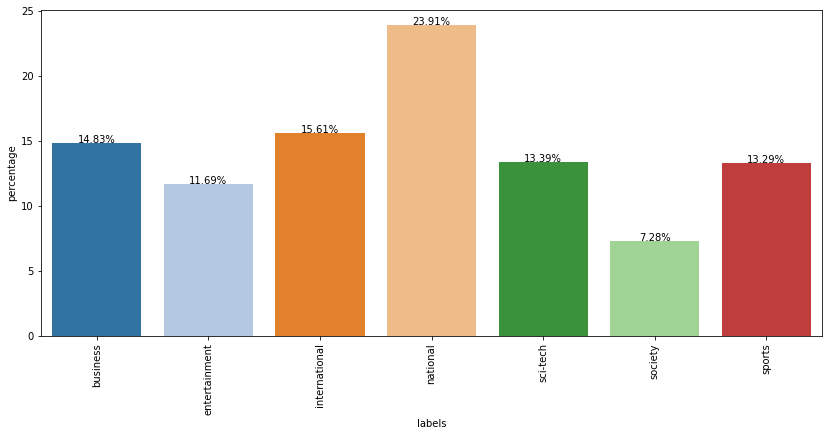

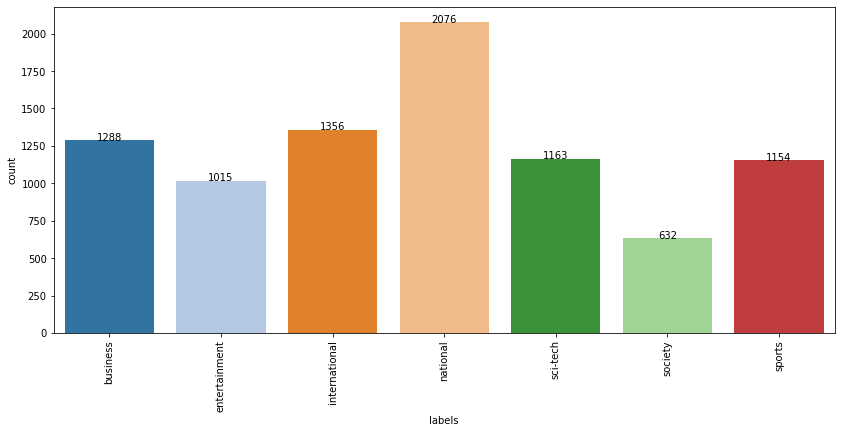

In [9]:
# df = pd.read_csv(raw_data_path)
def combine_labels(df):
  df['labels']=df.labels.replace(['business','economy','markets','cricket', 'races','other sports', 'entertainment', 'movies'], ['business','business','business', 'sports', 'sports','sports', 'entertainment', 'entertainment'])
  df['labels'] = df.labels.replace(['science','technology'],['sci-tech', 'sci-tech'])
  # drop travel row since it has really less data points
  df = df[df.labels != 'travel']
  # df = df[df.labels != 'national']
  return df
df_new = combine_labels(new_df)
plot_labels_percentage(df_new, file_name = 'reduced_label_data_percentage.jpg')
plot_labels_count(df_new, file_name = 'reduced_label_data_count.jpg')
# df_new.groupby(['labels']).count()['content']

In [10]:
df_temp = pd.DataFrame(df_new.groupby(['labels']).count()['content']).reset_index()
df_temp = df_temp.rename(columns={"content": "count"})
df_temp['percentage'] = (df_temp['count']/df_temp['count'].sum()) * 100
df_temp

,labels,count,percentage
0,business,1288,14.831875
1,entertainment,1015,11.688162
2,international,1356,15.614924
3,national,2076,23.906034
4,sci-tech,1163,13.392446
5,society,632,7.277752
6,sports,1154,13.288807


In [11]:
df_new.shape

(8709, 4)

## Cleaing

In [12]:
def remove_stop_words(data):
  word_list = word_tokenize(data)
  stops = set(stopwords.words("english"))
  filtered_words = [word for word in word_list if word not in stops]
  return " ".join(filtered_words)

def lemmatize_doc(doc):
  """
  Lemmatize a doc
  """
  lemma_sentence=[]
  wnl = WordNetLemmatizer()
  for word, tag in pos_tag(word_tokenize(doc)):
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
      lemma = word
    else:
      lemma = wnl.lemmatize(word, wntag)
    lemma_sentence.append(lemma)
    lemma_sentence.append(" ")
  return "".join(lemma_sentence)

def clean(data):
  """
  Args:
  data: single sentence
  """
  # remove functions body
  data = re.sub(r'(?<={)[^}]*', '', data)
  #remove function name
  data = re.sub('([\w]+ getPlayerID)', '', data)
  data = re.sub('loadAsyncURL.*', '', data)
  #remove unicodes
  data = re.sub(r'[^\x00-\x7f]',r'', data)
  data = data.replace('\x0c', '')
  data = data.replace('\x0d', '')
  data = data.replace('\f', '')
  data = data.replace('\n', ' ')

  # removing mentions 
  data = re.sub("@\S+", "", data)
  # remove market tickers
  data = re.sub("\$", "", data)
  # remove urls
  data = re.sub("https?:\/\/.*[\r\n]*", "", data)

  # removing hashtags 
  data = re.sub("#", "", data)

  # Remove ticks and the next character
  #Notley's tactful -> Notley tactful
  data = re.sub("\'\w+", '', data)

  #Remove Numbers
  data = re.sub(r'\w*\d+\w*', '', data)

  # remove all other symbols numbers and white spaces
  char_safe = ['.', '?', '!',]
  data = "".join([character if (character.isalnum() or character in char_safe) else " " for character in data])
  #remove ., ?, !
  data = data.replace('.', ' ')
  data = data.replace('?', ' ')
  data = data.replace('!', ' ')
  # remove extra white spce in the middle
  data = re.sub(" +", " ", data)
  #remove extra spaces in the beginning
  data = data.strip()

  #lowercase the text
  data = data.lower()
  return data

In [13]:
df_new = df_new[df_new['content'].notna()]
df_new.shape

(8684, 4)

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8684 entries, 0 to 1267
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  8684 non-null   object
 1   links     8684 non-null   object
 2   content   8684 non-null   object
 3   labels    8684 non-null   object
dtypes: object(4)
memory usage: 339.2+ KB


In [15]:
df_new['cleaned'] = df_new.content.apply(clean)
df_new['cleaned_no_sw'] = df_new['cleaned'].apply(remove_stop_words)
df_new['cleaned_no_sw_lemma'] = df_new['cleaned_no_sw'].apply(lemmatize_doc)
df_new.head()

,headline,links,content,labels,cleaned,cleaned_no_sw,cleaned_no_sw_lemma
0,Sindhu targets Olympics gold,https://www.thehindu.com/sport/other-sports/si...,World champion P.V. Sindhu said it is time to ...,sports,world champion p v sindhu said it is time to l...,world champion p v sindhu said time look ahead...,world champion p v sindhu say time look ahead ...
1,Shotgun selection trials from January 20,https://www.thehindu.com/sport/other-sports/sh...,The second and third shotgun selection trials ...,sports,the second and third shotgun selection trials ...,second third shotgun selection trials identify...,second third shotgun selection trial identify ...
2,Supreme Fragrance wins SI Oaks in style,https://www.thehindu.com/sport/races/star-frag...,Robert Foley-trained Supreme Fragrance (Nakha...,sports,robert foley trained supreme fragrance nakhat ...,robert foley trained supreme fragrance nakhat ...,robert foley train supreme fragrance nakhat si...
3,"Prevalent Force, Stormy Knight, Indian Democra...",https://www.thehindu.com/sport/races/prevalent...,"Prevalent Force, Stormy Knight, Indian Democr...",sports,prevalent force stormy knight indian democrat ...,prevalent force stormy knight indian democrat ...,prevalent force stormy knight indian democrat ...
4,Awesome One excels,https://www.thehindu.com/sport/races/awesome-o...,Awesome One excelled when the horses were exe...,sports,awesome one excelled when the horses were exer...,awesome one excelled horses exercised wednesda...,awesome one excelled horse exercise wednesday ...


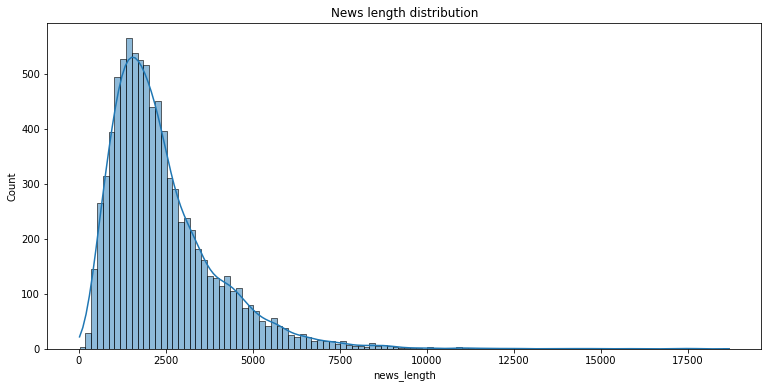

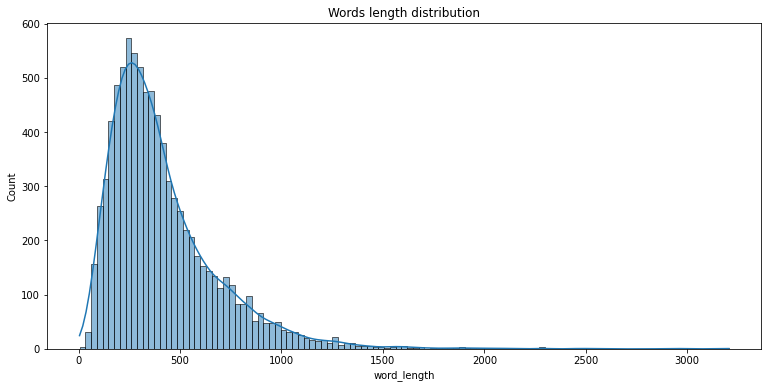

In [ ]:
def plot_news_length(df, file_name = 'news_length_distri.jpg'):
  df['news_length'] = df['cleaned'].str.len()
  df['word_length'] = df['cleaned'].apply(word_tokenize).apply(len)
  fig = plt.figure(figsize=(12.8,6))
  sns.histplot(df['news_length'], kde = True).set_title('News length distribution')
  dir_path = '/content/drive/MyDrive/news_analysis/assets/figs'
  file_name = os.path.join(dir_path, file_name)
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

def plot_word_length(df, file_name = 'words_length_distri.jpg'):
  df['word_length'] = df['cleaned'].apply(word_tokenize).apply(len)
  fig = plt.figure(figsize=(12.8,6))
  sns.histplot(df['word_length'], kde = True).set_title('Words length distribution')
  dir_path = '/content/drive/MyDrive/news_analysis/assets/figs'
  file_name = os.path.join(dir_path, file_name)
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

plot_news_length(df_new)
plot_word_length(df_new)

## Label Encoding

In [16]:
def label_encode(df):
  labels_code = {'business':0, 
                'entertainment':1,
                'international':2,
                'national':3,
                'sci-tech':4,
                'society':5,
                'sports':6
                }
  # numeric labels
  df['numeric_labels'] = df['labels']
  df = df.replace({'numeric_labels':labels_code})
  return df
df = label_encode(df_new)
df.head()

,headline,links,content,labels,cleaned,cleaned_no_sw,cleaned_no_sw_lemma,numeric_labels
0,Sindhu targets Olympics gold,https://www.thehindu.com/sport/other-sports/si...,World champion P.V. Sindhu said it is time to ...,sports,world champion p v sindhu said it is time to l...,world champion p v sindhu said time look ahead...,world champion p v sindhu say time look ahead ...,6
1,Shotgun selection trials from January 20,https://www.thehindu.com/sport/other-sports/sh...,The second and third shotgun selection trials ...,sports,the second and third shotgun selection trials ...,second third shotgun selection trials identify...,second third shotgun selection trial identify ...,6
2,Supreme Fragrance wins SI Oaks in style,https://www.thehindu.com/sport/races/star-frag...,Robert Foley-trained Supreme Fragrance (Nakha...,sports,robert foley trained supreme fragrance nakhat ...,robert foley trained supreme fragrance nakhat ...,robert foley train supreme fragrance nakhat si...,6
3,"Prevalent Force, Stormy Knight, Indian Democra...",https://www.thehindu.com/sport/races/prevalent...,"Prevalent Force, Stormy Knight, Indian Democr...",sports,prevalent force stormy knight indian democrat ...,prevalent force stormy knight indian democrat ...,prevalent force stormy knight indian democrat ...,6
4,Awesome One excels,https://www.thehindu.com/sport/races/awesome-o...,Awesome One excelled when the horses were exe...,sports,awesome one excelled when the horses were exer...,awesome one excelled horses exercised wednesda...,awesome one excelled horse exercise wednesday ...,6


In [ ]:
# df_new.word_length.nlargest(10)
# df_new.word_length.nsmallest(10)

In [17]:
def save_cleaned_df(df):
  data_dir = '/content/drive/MyDrive/news_analysis/assets/clean_data'

  #data with stop words and no lemmatization
  df_cleaned = df[['headline','links','cleaned','labels','numeric_labels']]
  data_path = os.path.join(data_dir, 'cleaned_articles.csv')
  df_cleaned.to_csv(data_path, encoding='utf-8', index=False)

  #data without stop words and no lemmatization
  df_cleaned_sw = df[['headline','links','cleaned_no_sw','labels', 'numeric_labels']]
  data_path = os.path.join(data_dir, 'cleaned_article_no_sw.csv')
  df_cleaned_sw.to_csv(data_path, encoding='utf-8', index=False)

  #data without stop words but with lemmatization
  df_cleaned_lemma = df[['headline','links', 'cleaned_no_sw_lemma','numeric_labels']]
  data_path = os.path.join(data_dir, 'cleaned_article_no_sw_lemma.csv')
  df_cleaned_lemma.to_csv(data_path, encoding='utf-8', index=False)
  # return df_cleaned
save_cleaned_df(df)
# df_cleaned.head()

In [18]:
def load_cleaned_data(removed_sw = False, lemmatized = False):
  data_dir = '/content/drive/MyDrive/news_analysis/assets/clean_data'
  if lemmatized:
    cleaned_data_path = os.path.join(data_dir, 'cleaned_article_no_sw_lemma.csv')
    df_cleaned = pd.read_csv(cleaned_data_path)
    df_cleaned = df_cleaned.rename(columns={"cleaned_no_sw_lemma": "cleaned_article"})
  elif removed_sw:
    cleaned_data_path = os.path.join(data_dir, 'cleaned_article_no_sw.csv')
    df_cleaned = pd.read_csv(cleaned_data_path)
    df_cleaned = df_cleaned.rename(columns={"cleaned_no_sw": "cleaned_article"})
  else:
    cleaned_data_path = os.path.join(data_dir, 'cleaned_articles.csv')
    df_cleaned = pd.read_csv(cleaned_data_path)
    df_cleaned = df_cleaned.rename(columns={"cleaned": "cleaned_article"})
  # df_cleaned = pd.read_csv(cleaned_data_path)
  return df_cleaned
df_cleaned = load_cleaned_data()
df_cleaned.head()

,headline,links,cleaned_article,labels,numeric_labels
0,Sindhu targets Olympics gold,https://www.thehindu.com/sport/other-sports/si...,world champion p v sindhu said it is time to l...,sports,6
1,Shotgun selection trials from January 20,https://www.thehindu.com/sport/other-sports/sh...,the second and third shotgun selection trials ...,sports,6
2,Supreme Fragrance wins SI Oaks in style,https://www.thehindu.com/sport/races/star-frag...,robert foley trained supreme fragrance nakhat ...,sports,6
3,"Prevalent Force, Stormy Knight, Indian Democra...",https://www.thehindu.com/sport/races/prevalent...,prevalent force stormy knight indian democrat ...,sports,6
4,Awesome One excels,https://www.thehindu.com/sport/races/awesome-o...,awesome one excelled when the horses were exer...,sports,6


In [19]:
df_cleaned.groupby('numeric_labels').count()['cleaned_article']

numeric_labels
0    1288
1    1015
2    1356
3    2076
4    1163
5     632
6    1154
Name: cleaned_article, dtype: int64

## Train-Test split

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df_new['cleaned'],
#                                                     df_new['numeric_labels'],
#                                                     test_size=0.10, 
#                                                     random_state=8)

In [ ]:
# with open('/content/drive/MyDrive/news_analysis/src/models/best_rfc.pickle', 'rb') as model:
#   rfc_best = pickle.load(model)
# print("The test accuracy is: ")
# print(accuracy_score(y_test, rfc_best.predict(features_test)))

## Vectorize text

In [20]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.8, frac_val=0.1, frac_test=0.1,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

## Training

In [21]:
def vectorize_text(df_cleaned, max_features = 300, frac_train=0.8, frac_val=0.1, frac_test=0.1):
  #consider top max_features
  tfidf = TfidfVectorizer(encoding='utf-8',
                          ngram_range=(1,2),
                          stop_words=None,
                          lowercase=False,
                          max_df=1.0,
                          min_df=10,
                          max_features = max_features,
                          norm='l2',
                          sublinear_tf=True
                          )

  #train val test split
  train, val, test = split_stratified_into_train_val_test(df_cleaned, 
                                                          stratify_colname='numeric_labels',
                                                          frac_train=frac_train, 
                                                          frac_val=frac_val, 
                                                          frac_test=frac_test
                                                          )


  x_train = train['cleaned_article']
  x_val = val['cleaned_article']
  x_test = test['cleaned_article']

  y_train = train['numeric_labels']
  y_val = val['numeric_labels']
  y_test = test['numeric_labels']
  
  features_train = tfidf.fit_transform(x_train).toarray()
  features_val = tfidf.transform(x_val).toarray()#never again use tfidf.fit_transform on val or test set
  features_test = tfidf.transform(x_test).toarray()#never again use tfidf.fit_transform
  print(features_train.shape, features_val.shape, features_test.shape)
  pickles_dir = '/content/drive/MyDrive/news_analysis/data_pickles'
  ###########################################################
  # x_train
  xtrain_p = os.path.join(pickles_dir, 'x_train.pickle')
  with open(xtrain_p, 'wb') as output:
    pickle.dump(x_train, output)
  # x_val
  xval_p = os.path.join(pickles_dir, 'x_val.pickle')
  with open(xval_p, 'wb') as output:
    pickle.dump(x_val, output)
  # x_test    
  xtest_p = os.path.join(pickles_dir, 'x_test.pickle')
  with open(xtest_p, 'wb') as output:
    pickle.dump(x_test, output)

  ########################################################   
  # y_train
  ytrain_p = os.path.join(pickles_dir, 'y_train.pickle')
  with open(ytrain_p, 'wb') as output:
    pickle.dump(y_train, output)
  # y_val
  yval_p = os.path.join(pickles_dir, 'y_val.pickle')
  with open(yval_p, 'wb') as output:
    pickle.dump(y_val, output)    
  # y_test
  ytest_p = os.path.join(pickles_dir, 'y_test.pickle')
  with open(ytest_p, 'wb') as output:
    pickle.dump(y_test, output)
  
  ###########################################################
  # features_train
  features_train_p = os.path.join(pickles_dir, 'features_train.pickle')
  with open(features_train_p, 'wb') as output:
    pickle.dump(features_train, output)
  # features_val
  features_val_p = os.path.join(pickles_dir, 'features_val.pickle')
  with open(features_val_p, 'wb') as output:
    pickle.dump(features_val, output)
  # features_test
  features_test_p = os.path.join(pickles_dir, 'features_test.pickle')
  with open(features_test_p, 'wb') as output:
    pickle.dump(features_test, output)

  ###########################################################
  # df_cleaned
  df_cleaned_p = os.path.join(pickles_dir, 'df_cleaned.pickle')
  with open(df_cleaned_p, 'wb') as output:
    pickle.dump(df_cleaned, output)   
  # TF-IDF object
  tfidf_p = os.path.join(pickles_dir, 'tfidf.pickle')
  with open(tfidf_p, 'wb') as output:
    pickle.dump(tfidf, output)
  print(df_cleaned.shape)
  return features_train, y_train, features_val, y_val, features_test, y_test
features_train, labels_train, features_val, labels_val, features_test, labels_test = vectorize_text(df_cleaned)

(6947, 300) (868, 300) (869, 300)
(8684, 5)


In [22]:
base_rfc = RandomForestClassifier(random_state = 8)
base_rfc.fit(features_train, labels_train)
print("The training accuracy is: ")
print(accuracy_score(labels_train, base_rfc.predict(features_train)))
print("The val accuracy is: ")
print(accuracy_score(labels_val, base_rfc.predict(features_val)))
print("The test accuracy is: ")
print(accuracy_score(labels_test, base_rfc.predict(features_test)))

The training accuracy is: 
1.0
The val accuracy is: 
0.7799539170506913
The test accuracy is: 
0.807825086306099


In [23]:
# Classification report
print("Classification report")
print(classification_report(labels_test,base_rfc.predict(features_test)))

Classification report
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       129
           1       0.88      0.83      0.85       101
           2       0.83      0.71      0.77       136
           3       0.73      0.91      0.81       208
           4       0.83      0.76      0.79       117
           5       0.77      0.75      0.76        63
           6       0.88      0.83      0.85       115

    accuracy                           0.81       869
   macro avg       0.82      0.80      0.81       869
weighted avg       0.81      0.81      0.81       869



In [33]:
model_dir = '/content/drive/MyDrive/news_analysis/src/models'
rfc_path = os.path.join(model_dir,'base_rfc.pickle')
with open(rfc_path, 'wb') as output:
    pickle.dump(base_rfc, output)

In [34]:
with open(rfc_path, 'rb') as model:
  model = pickle.load(model)
print("The test accuracy is: ")
print(accuracy_score(labels_test, model.predict(features_test)))

The test accuracy is: 
0.807825086306099


## Cross Validation

### Random Forest
#### Parameters to tune
`n_estimators`: number of trees in the forest.

`max_features`: max number of features considered for splitting a node

`max_depth`: max number of levels in each decision tree

`min_samples_split`: min number of data points placed in a node before the node is split

`min_samples_leaf`: min number of data points allowed in a leaf node

`bootstrap`: method for sampling data points (with or without replacement)

In [24]:
def cv_randomized(features_val, labels_val):

  # n_estimators
  n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

  # max_features
  max_features = ['auto', 'log2', 50]

  # max_depth
  max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
  max_depth.append(None)

  # min_samples_split
  min_samples_split = [2, 5, 10]

  # min_samples_leaf
  min_samples_leaf = [1, 2, 4]

  # bootstrap
  bootstrap = [True, False]

  # Create the random grid
  random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

  pprint(random_grid)
  # First create the base model to tune
  rfc = RandomForestClassifier(random_state=8)

  # Definition of the random search
  random_search = RandomizedSearchCV(estimator=rfc,
                                    param_distributions=random_grid,
                                    n_iter=50,
                                    scoring='accuracy',
                                    cv=3, 
                                    verbose=1, 
                                    random_state=8)

  # Fit the random search model
  random_search.fit(features_val, labels_val)
  return random_search

random_search = cv_randomized(features_train, labels_train)
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'log2', 50],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits
The best hyperparameters from Random Search are:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.8209307400485683


In [28]:
res_dict = random_search.cv_results_

In [30]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
config_dir = '/content/drive/MyDrive/news_analysis/configs'
config_path = os.path.join(config_dir, 'rfc_random_search.json')
with open(config_path, 'w') as f:
  json.dump(res_dict, f, indent = 4, cls=NumpyEncoder)

In [ ]:
# Create the parameter grid based on the results of random search 
def cv_grid(features_val, labels_val):
  bootstrap = [False]
  max_depth = [None]
  max_features = ['auto','log2']
  min_samples_leaf = [1, 2, 8]
  min_samples_split = [2, 5, 10]
  n_estimators = [100, 200, 400]

  param_grid = {
      'bootstrap': bootstrap,
      'max_depth': max_depth,
      'max_features': max_features,
      'min_samples_leaf': min_samples_leaf,
      'min_samples_split': min_samples_split,
      'n_estimators': n_estimators
      }

  # Create a base model
  rfc = RandomForestClassifier(random_state=8)

  # Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
  cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator=rfc, 
                            param_grid=param_grid,
                            scoring='accuracy',
                            cv=cv_sets,
                            return_train_score=True,
                            verbose=10)

  # Fit the grid search to the data
  grid_search.fit(features_val, labels_val)
  return grid_search
grid_search = cv_grid(features_train, labels_train)

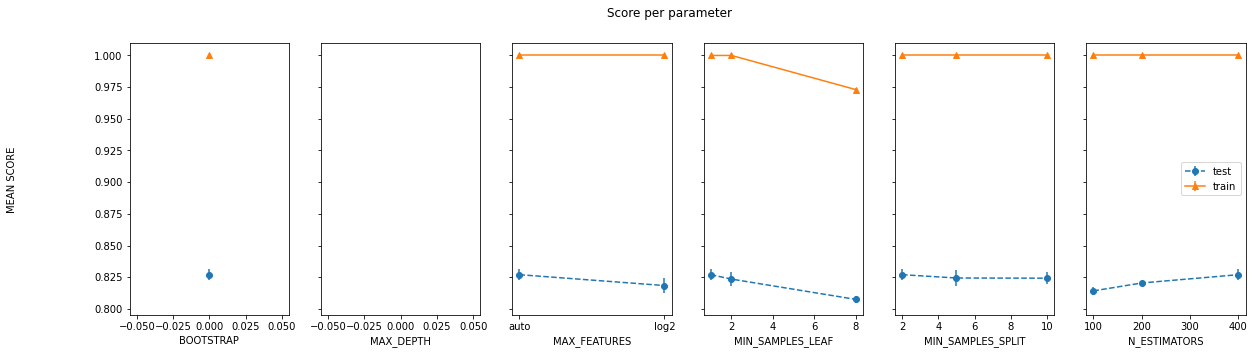

In [52]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()


plot_search_results(grid_search)
# plot_grid_search(grid_search.cv_results_, n_estimators, max_features, 'N Estimators', 'Max Features')

In [53]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [37]:
best_rfc = grid_search.best_estimator_
print(best_rfc)
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)
# Training  and test accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))
print("The val accuracy is: ")
print(accuracy_score(labels_val,  best_rfc.predict(features_val)))

RandomForestClassifier(bootstrap=False, n_estimators=400, random_state=8)
The training accuracy is: 
1.0
The test accuracy is: 
0.8181818181818182
The val accuracy is: 
0.8018433179723502


In [38]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       129
           1       0.87      0.81      0.84       101
           2       0.85      0.76      0.80       136
           3       0.75      0.91      0.82       208
           4       0.83      0.79      0.81       117
           5       0.73      0.78      0.75        63
           6       0.90      0.82      0.85       115

    accuracy                           0.82       869
   macro avg       0.83      0.81      0.81       869
weighted avg       0.82      0.82      0.82       869



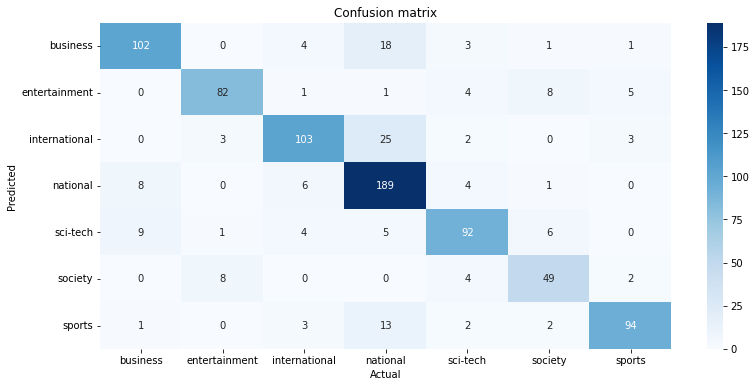

In [40]:
aux_df = df[['labels', 'numeric_labels']].drop_duplicates().sort_values('numeric_labels')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues",
            fmt='d')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

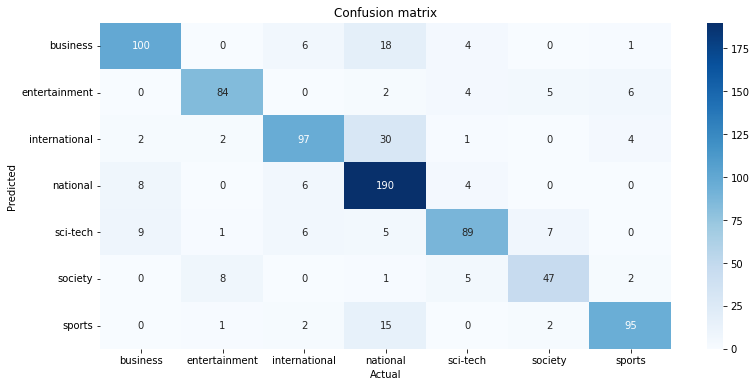

In [43]:
rfc_pred_base = base_rfc.predict(features_test)
aux_df = df[['labels', 'numeric_labels']].drop_duplicates().sort_values('numeric_labels')
conf_matrix = confusion_matrix(labels_test, rfc_pred_base)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues",
            fmt = 'd')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [44]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, best_rfc.predict(features_test))
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [45]:
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,1.0,0.818182


In [46]:
model_dir = '/content/drive/MyDrive/news_analysis/src/models'
rfc_path = os.path.join(model_dir,'best_rfc.pickle')
res_path = os.path.join(model_dir, 'df_models_rfc.pickle')
with open(rfc_path, 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open(res_path, 'wb') as output:
    pickle.dump(df_models_rfc, output)

In [64]:
### Check the result on random text
labels_decode = {
                0:'business', 
                1:'entertainment',
                2:'international',
                3:'national',
                4:'sci-tech',
                5:'society',
                6:'sports'
              }
model_dir = '/content/drive/MyDrive/news_analysis/src/models'
pickles_dir = '/content/drive/MyDrive/news_analysis/data_pickles'
rfc_path = os.path.join(model_dir,'best_rfc.pickle')
tfidf_p = os.path.join(pickles_dir, 'tfidf.pickle')

with open(rfc_path, 'rb') as model:
  model = pickle.load(model)

with open(tfidf_p, 'rb') as tfidf:
  tfidf = pickle.load(tfidf)

text = r'''Twitter Inc said on Friday its engineering head Michael Montano and design chief Dantley Davis would step down from their roles by the end of this month, as part of a broader management restructuring at the social networking site.

(Sign up to our Technology newsletter, Today's Cache, for insights on emerging themes at the intersection of technology, business and policy. Click here to subscribe for free.)

The moves come just days after co-founder Jack Dorsey stepped down as chief executive officer and handed over the reins to Chief Technology Officer Parag Agrawal.

Twitter said Agrawal, in his newly assumed role, has decided to reorganise the leadership structure at the company and shift to a general manager model for consumer, revenue and core tech that would oversee all core teams across engineering, product management, design and research.'''
text = clean(text)
feat = tfidf.transform([text])
labels_decode[model.predict(feat)[0]]

'sci-tech'